In [2]:
# Librairies personnalisées
from my_functions.common_functions import *
from my_functions.machine_learning_common_functions import *
from my_functions.dimensionality_reduction_functions import *
from my_functions.BorutaLGBM import BorutaPyForLGB
from BorutaShap import BorutaShap

from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from flaml import AutoML
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from lightgbm import LGBMClassifier, early_stopping, Dataset, cv, plot_tree, plot_metric, plot_importance
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, log_loss
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from sklearn.model_selection import StratifiedKFold
import shap

import gc
import re
import time
import dill

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

# # Supress unnecessary warnings so that presentation looks clean
# import warnings
# warnings.filterwarnings("ignore")

# 1. Chargement des Données

In [2]:
path_data = './Projet+Mise+en+prod+-+home-credit-default-risk/'

In [3]:
df = pd.read_csv(path_data+'data.csv')

In [4]:
if "SK_ID_CURR" in df.columns.tolist():
    df = df.drop(columns="SK_ID_CURR")

Le data set contient :
	- 307505 lignes et 530 colonnes.
	- 0 valeurs manquantes, ce qui représente 0.0 % du data set.


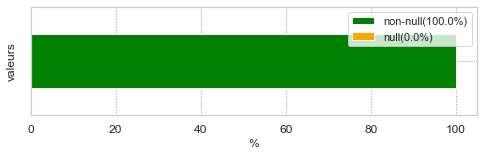

Voici un sous-échantillon aléatoire :


TARGET  GENDER  OWN_CAR  OWN_REALTY  AMT_ANNUITY  AMT_GOODS_PRICE  \
42762      0.0     1.0      1.0         1.0      26154.0         675000.0   
209498     0.0     1.0      0.0         0.0      25159.5         270000.0   
263740     0.0     1.0      0.0         1.0       9000.0         180000.0   
105076     0.0     1.0      0.0         0.0      11214.0          99000.0   
271025     0.0     0.0      1.0         0.0      20641.5         382500.0   
...        ...     ...      ...         ...          ...              ...   
177167     0.0     1.0      0.0         0.0      13041.0         180000.0   
174281     0.0     1.0      1.0         0.0      25618.5         499500.0   
36701      0.0     0.0      1.0         0.0      25803.0         477000.0   
183902     0.0     0.0      0.0         0.0      26874.0         225000.0   
272878     1.0     1.0      0.0         1.0      30717.0         913500.0   

        REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  FLAG_MOBIL  \
42762                     0.030762            -3932.0         1.0   
209498                    0.011658              -42.0         1.0   
263740                    0.030762            -2468.0         1.0   
105076                    0.030762             -306.0         1.0   
271025                    0.024612             -951.0         1.0   
...                            ...                ...         ...   
177167                    0.022629            -8656.0         1.0   
174281                    0.018799            -4792.0         1.0   
36701                     0.025162            -6696.0         1.0   
183902                    0.019684             -956.0         1.0   
272878                    0.010033            -2044.0         1.0   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
42762              1.0              0.0               1.0         0.0   
209498             0.0              0.0               1.0         1.0   
263740             1.0              0.0               1.0         0.0   
105076             0.0              0.0               1.0         0.0   
271025             1.0              0.0               1.0         0.0   
...                ...              ...               ...         ...   
177167             0.0              0.0               1.0         1.0   
174281             1.0              0.0               1.0         0.0   
36701              1.0              0.0               1.0         0.0   
183902             1.0              0.0               1.0         0.0   
272878             1.0              0.0               1.0         0.0   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
42762          0.0              2.0                   2.0   
209498         1.0              1.0                   1.0   
263740         0.0              2.0                   2.0   
105076         0.0              2.0                   2.0   
271025         0.0              3.0                   2.0   
...            ...              ...                   ...   
177167         0.0              2.0                   2.0   
174281         0.0              2.0                   2.0   
36701          1.0              2.0                   2.0   
183902         0.0              3.0                   2.0   
272878         0.0              2.0                   2.0   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
42762                      18.0                         0.0   
209498                     13.0                         0.0   
263740                     11.0                         1.0   
105076                     11.0                         0.0   
271025                     11.0                         0.0   
...                         ...                         ...   
177167                      9.0                         0.0   
174281                     14.0                         0.0   
36701                      11.0                         0.0   
183902        

In [5]:
verifier_taille(df)
afficher_echantillon(df, n=1000, frac=1.)

# 2. Features Selection : Boruta-SHAP

In [6]:
x_train, x_test, y_train, y_test = trainning_sets(df, 'TARGET')

In [ ]:
lgbm_params = {
    'device_type':'gpu',
    'scale_pos_weight':(len(y_train)-sum(y_train))/sum(y_train),                            
    'random_state':0,
    'verbose':2,
    'n_jobs':-1,
    'n_estimators':100,
    'learning_rate':0.2,
    'max_depth':6,
    'num_leaves':30,
    'colsample_bytree':0.613,
    'subsample':0.708,
    'max_bin':63,
    'reg_alpha':3.564,
    'reg_lambda':4.930,
    'min_child_weight':6,
    'min_child_samples':165,   
}

model = LGBMClassifier(**lgbm_params)
selector = BorutaShap(model=model, importance_measure = 'shap', classification = True)
selector.fit(X = pd.DataFrame(x_train, columns=df.drop(columns='TARGET').columns), y = y_train, n_trials = 50, random_state=0, sample=False, normalize=False, verbose = True)
# n_trials -> number of iterations for Boruta algorithm
# sample -> samples the data so it goes faster

In [7]:
# Display features to be removed
features_to_remove = selector.features_to_remove
print(features_to_remove)

['OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'OBS_30_CNT_SOCIAL_CIRCLE'
 'OBS_60_CNT_SOCIAL_CIRCLE' 'DEF_60_CNT_SOCIAL_CIRCLE'
 'DAYS_LAST_PHONE_CHANGE' 'FLAG_DOCUMENT_2' 'FLAG_DOCUMENT_4'
 'FLAG_DOCUMENT_5' 'FLAG_DOCUMENT_6' 'FLAG_DOCUMENT_7' 'FLAG_DOCUMENT_8'
 'FLAG_DOCUMENT_9' 'FLAG_DOCUMENT_10' 'FLAG_DOCUMENT_11'
 'FLAG_DOCUMENT_12' 'FLAG_DOCUMENT_13' 'FLAG_DOCUMENT_14'
 'FLAG_DOCUMENT_15' 'FLAG_DOCUMENT_16' 'FLAG_DOCUMENT_17'
 'FLAG_DOCUMENT_18' 'FLAG_DOCUMENT_19' 'FLAG_DOCUMENT_20'
 'FLAG_DOCUMENT_21' 'AMT_REQ_CREDIT_BUREAU_HOUR'
 'AMT_REQ_CREDIT_BUREAU_DAY' 'AMT_REQ_CREDIT_BUREAU_WEEK'
 'AMT_REQ_CREDIT_BUREAU_MON' 'AMT_REQ_CREDIT_BUREAU_YEAR'
 'CONTRAC

In [8]:
dfbs = df.drop(columns=features_to_remove)
dfbs.to_csv(path_data+'data-boruta-shap.csv', index=False)
df = dfbs

# 3. Entrainement du Modèle

In [5]:
def save(path, obj):
    with open('./pkl/'+path,'wb') as io:
        dill.dump(obj, io)

def load(path):
    with open('./pkl/'+path,'rb') as io:
        return dill.load(io) 

In [6]:
# Préparation des différents sets

# Sets classiques
x_train, x_test, y_train, y_test = None, None, None, None
try:
    x_train = load('x_train.pkl')
    x_test = load('x_test.pkl')
    y_train = load('y_train.pkl')
    y_test = load('y_test.pkl')
except:
    x_train, x_test, y_train, y_test = trainning_sets(df, 'TARGET')
    save('x_train.pkl', x_train)
    save('x_test.pkl', x_test)
    save('y_train.pkl',y_train)
    save('y_test.pkl', y_test)

# Sets équilibrés
X_eq = x_train.values
y_eq = y_train
try:
    X_eq = load('X_eq.pkl')
    y_eq = load('y_eq.pkl')
except:
    X_eq, y_eq = SMOTETomek(sampling_strategy=0.7, smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(X_eq, y_eq)
    save('X_eq.pkl', X_eq)
    save('y_eq.pkl', y_eq)

# Stratified Folds équilibrés
X_sk = {'train':[], 'val':[]}
y_sk = {'train':[], 'val':[]}
try:
    X_sk = load('X_sk.pkl')
    y_sk = load('y_sk.pkl')
except:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    X = x_train.values
    y = y_train
    
    for train_index, test_index in skf.split(X, y):
        X_train_skf, X_test_skf = X[train_index], X[test_index]
        y_train_skf, y_test_skf = y[train_index], y[test_index]

        X_res, y_res = SMOTETomek(sampling_strategy=0.7, smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(X_train_skf, y_train_skf)
        X_sk['train'].append(X_res)
        y_sk['train'].append(y_res)
        X_sk['val'].append(X_test_skf)
        y_sk['val'].append(y_test_skf)
    save('X_sk.pkl', X_sk)
    save('y_sk.pkl', y_sk)

In [ ]:
# Sélection des scores pour l'évaluation des modèles
scores = ['AUC', 'FN']
hue='AUC'

Perfs = None
try :
    # Chargement des Perfs précédentes
    Perfs = pd.read_csv('Perfs.csv')
except:
    Perfs = pd.DataFrame(columns=['Model']+scores, index=[])

display(Perfs)

def saveScore(model_name, local_scores):
    global Perfs
    global scores
    global hue

    # Evaluatation
    i = len(Perfs)
    Perfs.loc[i, 'Model'] = model_name
    for score in scores:
        Perfs.loc[i, score] = local_scores[score]
        Perfs[score] = Perfs[score].astype('float') 
    Perfs.loc[i, 'Time(s)'] = local_scores['time']
    print('Time:', local_scores['time'])
    if hue != None:
        Perfs.loc[i, 'hue'] = hue

In [8]:
# Foncton de sauvegarde du modèle
def saveModel(model, model_name='model'):
    ### Create a Pickle file using serialization 
    with open('./pkl/'+model_name+".pkl",'wb') as io:
        dill.dump(model,io)

# Fonction daffichage de l'évaluation du modèle
def EvalDisplay(model, metric, model_name, elapsed):
    local_scores = {}
    y_predict = model.predict(x_test)
    y_predict_proba = model.predict_proba(x_test)[:,1]
    print('Socre:', metric(y_test, y_predict))

    #ROC
    local_scores['AUC'] = AUC(y_test, y_predict_proba, y_train, model.predict_proba(x_train)[:,1])

    # Confusion Matrix        
    cm = confusion_matrix(y_test, y_predict, labels=model.classes_)    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    print(cm)

    local_scores['FN'] = cm[1, 0]
    local_scores['time'] = elapsed

    # Save model scores
    saveScore(model_name, local_scores)
    #Save the model
    saveModel(model, model_name)

# Métrique d'évaluation du modèle : AUC
def MyScore(y_test, y_pred):
    return roc_auc_score(y_test, y_pred)

## 3.1. Avec Fonction de Coût Classique : AUC

Dans le but d'évaluer la pertinence de la fonction de coût métiers adaptée à la problématique, une première phase d'entrainement du modèle se fait avec une fonction classique, dans cas l'AUC qui fera office de référence.

### 3.1.1. Modèle Baseline : LogisticRegressionCV

Avant d'entrainer le modèle final, il faut d’abord établir un modèle de référence (baseline) pour évaluer l’évolution de la performance du modèle.
La Baseline choisie est une régression logistique cross-validée, qui pour prédire la classe, combine linéairement les variables pondérées plus des termes de régulation.

In [9]:
def train_baseline(scoring):
    start = time.time()
    lr = LogisticRegressionCV(cv=10, scoring=make_scorer(scoring), random_state=0, n_jobs=-1).fit(x_train, y_train)
    elapsed = (time.time() - start) 
    EvalDisplay(lr, MyScore, 'baseline_auc', elapsed)    

Socre: 0.5002170973665808


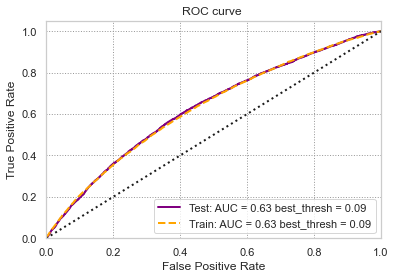

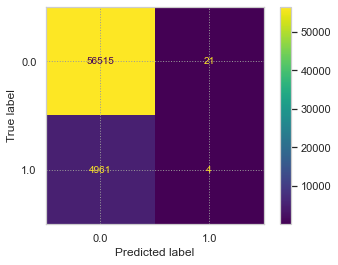

[[56515    21]
 [ 4961     4]]
Time: 656.1079978942871


In [10]:
train_baseline(MyScore)

La baseline donne de meilleurs résultats qu'un modèle aléatoire (AUC=0.5). Tous les modèles suivants seront comparés à cette baseline.

### 3.1.2. Modèle Classique : LGBM

Le modèle réel sélectionné est LightGBM, qui réalise du gradient boosting sur un arbre de décision de manière efficace et rapide avec moins de mémoire et une plus forte précision. Les hyperparamètres du modèle sont choisis à partir des noyaux/scripts Kaggle réalisé sur cette problématique.

In [154]:
# Hyperparamètres pour LGBM
lgbm_params = {
    'device_type':'gpu',
    'scale_pos_weight':(len(y_train)-sum(y_train))/sum(y_train),                                
    'verbose':2,
    'n_jobs':-1,
    'n_estimators':5000,
    'learning_rate':0.01,
    'max_depth':11,
    'num_leaves':58,
    'colsample_bytree':0.613,
    'subsample':0.708,
    'max_bin':63,
    'reg_alpha':3.564,
    'reg_lambda':4.930,
    'min_child_weight':6,
    'min_child_samples':165,   
}

# Métrique d'évaluation adaptée à LGBM
def lgbm_metric(y, preds):   
    # # eval_name, eval_result, is_higher_better
    return 'auc', MyScore(y, preds), True

# Fonction d'entrainement basique d'un modèle LGBM
def trainLGBM(params, metric, name):
    model = LGBMClassifier(**params)       

    start = time.time()
    model = model.fit(X_eq, y_eq, eval_set=[(x_test, y_test)], eval_metric=metric)    
    elapsed = (time.time() - start) 
    print(model.best_score_)
    
    EvalDisplay(model, MyScore, name, elapsed)    

    return model

# Fonction d'entrainement d'un modèle LGBM avec une validation croisée
def trainLGBM_CV(params, metric, name, elapsed=0):
  best_score = 0
  best_model = None
  start = time.time()
  
  for i in range(len(X_sk)):
    X_res, y_res = X_sk['train'][i], y_sk['train'][i]
    X_val, y_val = X_sk['val'][i], y_sk['val'][i]
    model = LGBMClassifier(**params)
    model.fit(X_res, y_res, eval_set=[(X_val, y_val)], eval_metric=metric,  callbacks=[early_stopping(stopping_rounds=5, min_delta=0.001)])
    y_pred = model.predict_proba(x_test)[:,1]
    score = MyScore(y_test, y_pred)
    if score > best_score:
      best_score = score
      best_model = model
  
  elapsed += (time.time() - start) 
  EvalDisplay(best_model, MyScore, name, elapsed)

  return best_model

[LightGBM] [Info] Number of positive: 224321, number of negative: 224321
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.880000
[LightGBM] [Info] Total Bins 31994
[LightGBM] [Info] Number of data points in the train set: 448642, number of used features: 511
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 236 dense feature groups (100.97 MB) transferred to GPU in 0.065838 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 11
[1]	valid_0's binary_logloss: 0.694886	valid_0's auc: 0.672933
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 11
[2]	valid_0's binary_logloss: 0.696608	va

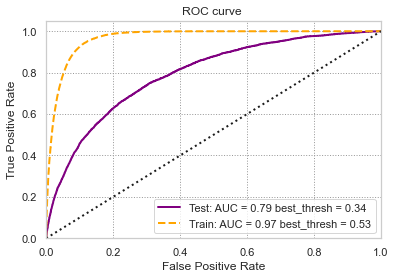

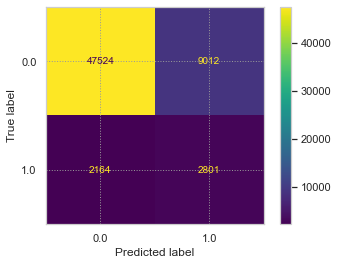

[[47524  9012]
 [ 2164  2801]]
Time: 756.5319969654083


In [12]:
lgbm = trainLGBM(lgbm_params, lgbm_metric, 'lgbm')

Ce premier modèle LGBM performe mieux que la baseline. En revanche, la très haute AUC sur le train set et la moins bonne AUC sur le test set semblent indiquer un surapprentissage (overfitting) du modèle.
<br/>
Pour éviter ce problème, de nouvelles valeurs des hypermètres sont testées pour obtenir un modèle plus léger et moins risqué au surapprentissage.

In [155]:
# Autres valeurs des Hyperparamètres pour LGBM encore plus léger
lgbm_params2 = dict(lgbm_params)
lgbm_params2['n_estimators']=100
lgbm_params2['learning_rate']=0.2
lgbm_params2['max_depth']=6
lgbm_params2['num_leaves']=30

[LightGBM] [Info] Number of positive: 224321, number of negative: 224321
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.880000
[LightGBM] [Info] Total Bins 31994
[LightGBM] [Info] Number of data points in the train set: 448642, number of used features: 511
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 236 dense feature groups (100.97 MB) transferred to GPU in 0.057844 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[1]	valid_0's binary_logloss: 0.750791	valid_0's auc: 0.670594
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[2]	valid_0's binary_logloss: 0.797316	vali

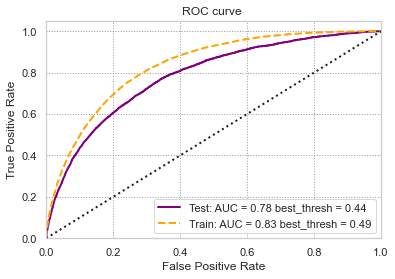

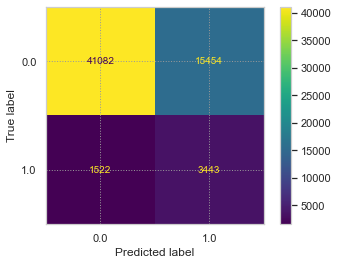

[[41082 15454]
 [ 1522  3443]]
Time: 20.14199447631836


In [14]:
lgbml = trainLGBM(lgbm_params2, lgbm_metric, 'lgbml')

Ce deuxième modèle LGBM, plus léger, semble ne pas surapprendre, comparé au modèle précédent. De plus, il réduit le taux de Faux Négatifs (à la défaveur du taux de Faux Positifs). <br/>
On passe maintenant à l’entrainement du modèle avec une validation croisée.

[LightGBM] [Info] Number of positive: 179488, number of negative: 179488
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.878919
[LightGBM] [Info] Total Bins 31890
[LightGBM] [Info] Number of data points in the train set: 358976, number of used features: 510
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 236 dense feature groups (80.79 MB) transferred to GPU in 0.054834 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[Ligh

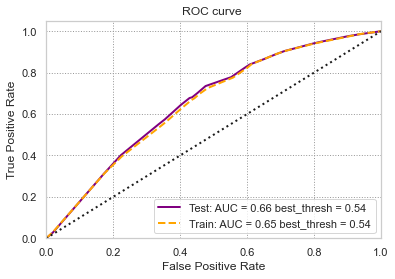

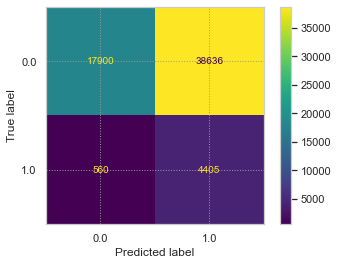

[[17900 38636]
 [  560  4405]]
Time: 22.328999042510986


In [156]:
lgbml_cv = trainLGBM_CV(lgbm_params2, lgbm_metric, 'lgbml_cv')

Certes, ce modèle validé est moins performant que les modèles LGBM précédents en termes de métrique AUC. En revanche, les matrices de confusion indiquent que ce modèle validé a le plus faible taux de Faux Négatifs, au détriment du taux de Faux Positifs (d’où la réduction de l’AUC).

### 3.1.3. Optimisation du Modèle LGBM

Deux méthodes d’optimisation (semi-)automatique des hyperparamètres sont testées sur le modèle LGBM.

#### 3.1.3.1. FlaML

In [16]:
def flamlLGBM(time_budget=60, metric='roc_auc', name='flamlgbm'):    
    automl_settings = {
        "time_budget": time_budget,  # in seconds
        "metric": metric,
        "task": 'classification',
        "estimator_list": ["lgbm"],
        "split_type":'stratified', 
        "eval_method": 'cv',
        "n_splits":5,
        "n_jobs":-1,
    }

    automl = AutoML()
    start = time.time()
    automl.fit(X_train=X_eq, y_train=y_eq, **automl_settings)
    
    elapsed = (time.time() - start) 
    best_config = automl.best_config
    print('>>>>> Best hyperparmeter config:', best_config)    

    trainLGBM_CV(best_config, lgbm_metric, name, elapsed)

[flaml.automl: 09-12 17:15:12] {2565} INFO - task = classification
[flaml.automl: 09-12 17:15:12] {2567} INFO - Data split method: stratified
[flaml.automl: 09-12 17:15:12] {2570} INFO - Evaluation method: cv
[flaml.automl: 09-12 17:15:28] {2689} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 09-12 17:15:28] {2831} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 09-12 17:15:28] {3133} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-12 17:16:33] {3266} INFO - Estimated sufficient time budget=644830s. Estimated necessary time budget=645s.
[flaml.automl: 09-12 17:16:33] {3313} INFO -  at 80.4s,	estimator lgbm's best error=0.1418,	best estimator lgbm's best error=0.1418
[flaml.automl: 09-12 17:16:33] {3133} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-12 17:17:35] {3313} INFO -  at 143.0s,	estimator lgbm's best error=0.1283,	best estimator lgbm's best error=0.1283
[flaml.automl: 09-12 17:17:35] {3133} INFO - iteration 2, current learner 

>>>>> Best hyperparmeter config: {'n_estimators': 603, 'num_leaves': 42, 'min_child_samples': 10, 'learning_rate': 0.035486773362072024, 'log_max_bin': 7, 'colsample_bytree': 0.33249530344693906, 'reg_alpha': 0.0010836280588796038, 'reg_lambda': 0.0015015946171746538}
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.250377	valid_0's auc: 0.761693
[LightGBM] [Warning] Unknown parameter: log_max_bin
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.365242	valid_0's auc: 0.723979
Socre: 0.5009274540433096


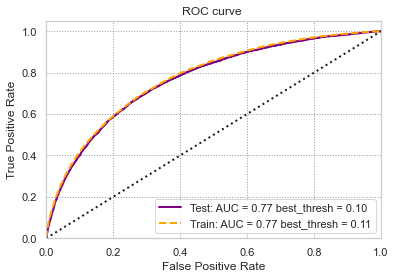

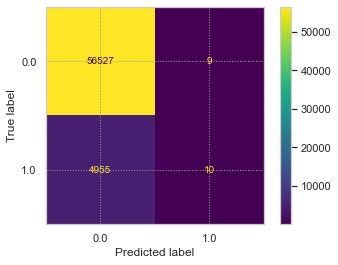

[[56527     9]
 [ 4955    10]]
Time: 3689.800492286682


In [17]:
flamlLGBM(time_budget=3600)

Après 1h d’optimisation, le modèle produit par FlaML est le pire jusqu’à présent, en termes de matrice de confusion : très faible taux de Positifs et fort taux de Faux Négatifs.

#### 3.1.3.2. HyperOPT

In [80]:
# define the function we want to minimise
def MyModel(params):  
  print('>>>> Current params',params)
  model = LGBMClassifier(device='gpu',random_state=0, verbose=-1, n_jobs=-1, **params) 
  return model  

def objective(params):
  best_score = 0
  scores = []
  for i in range(len(X_sk)):
    X_res, y_res = X_sk['train'][i], y_sk['train'][i]
    X_val, y_val = X_sk['val'][i], y_sk['val'][i]
    model = MyModel(params)
    try:
      model.fit(X_res, y_res, eval_set=[(X_val, y_val)], eval_metric=lgbm_metric,  callbacks=[early_stopping(stopping_rounds=5, min_delta=0.001)])
      y_pred = model.predict(x_test)
      score = MyScore(y_test, y_pred)
      scores.append(score)
      if score > best_score:
        best_score = score
    except:
      pass
  return {'loss': -np.mean(scores), 'status': STATUS_OK}

search_space  = dict([
                    ('sampling_strategy', hp.uniform('sampling_strategy', 0.1, 1.)),
                    ('n_estimators', hp.choice('n_estimators', range(40, 200, 20))),
                    ('learning_rate', hp.uniform('learning_rate', 0.05, 0.3)),
                    ('max_depth', hp.choice('max_depth', range(4, 9, 2))),
                    ('num_leaves', hp.choice('num_leaves', range(5, 50, 5))),
                    ('max_bin', hp.choice('max_bin', range(50, 150, 10))),
                    ('reg_alpha', hp.loguniform('reg_alpha', 
                                                     np.log(0.1), np.log(10.))),
                    ('reg_lambda', hp.loguniform('reg_lambda', 
                                                     np.log(0.1), np.log(10.))),
                    ('min_child_weight', hp.loguniform('min_child_weight', 
                                                     np.log(0.001), np.log(10.))),
                    ('num_leaves', hp.choice('num_leaves', range(2, 100, 1))),
                    ('colsample_bytree', hp.uniform('colsample_bytree', 0.1, 1.0)),
                    ('subsample', hp.uniform('subsample', 0.1, 1.0)),
                    ('min_child_samples', hp.choice('min_child_samples', range(10, 1000, 10)))
                    ])
                    
# set the hyperparam tuning algorithm
algorithm=tpe.suggest

def hyperoptLGBM(max_evals=20, eval_metric=roc_auc_score, name='lgbmh'):
  start = time.time()
  best_params = fmin(
    fn=objective,
    space=search_space,
    algo=algorithm,
    max_evals=max_evals)

  elapsed = (time.time() - start) 

  # Convert index(int) params to the equivalent value
  best_params = space_eval(search_space, best_params)
  print('>>>> best_params', best_params)
  
  trainLGBM_CV(best_params, lgbm_metric, name, elapsed)

>>>> Current params                                    
{'colsample_bytree': 0.7668911297037434, 'learning_rate': 0.08191151854714053, 'max_bin': 60, 'max_depth': 8, 'min_child_samples': 220, 'min_child_weight': 0.10409504602418088, 'n_estimators': 100, 'num_leaves': 79, 'reg_alpha': 0.48639498772657225, 'reg_lambda': 0.4232475870409641, 'sampling_strategy': 0.3708740653168584, 'subsample': 0.4163862071505505}
[LightGBM] [Warning] Unknown parameter: sampling_strategy
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.              
Early stopping, best iteration is:                     
[71]	valid_0's binary_logloss: 0.246006	valid_0's auc: 0.763667
>>>> Current params                                    
{'colsample_bytree': 0.7668911297037434, 'learning_rate': 0.08191151854714053, 'max_bin': 60, 'max_depth': 8, 'min_child_samples': 220, 'min_child_weight': 0.10409504602418088, 'n_estimators': 100, 'num_leaves': 79, 'reg_alpha': 0.48639

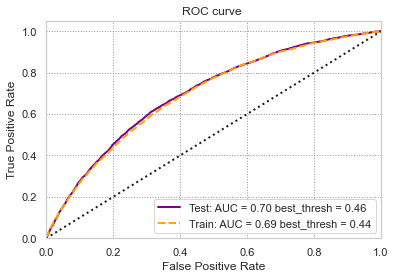

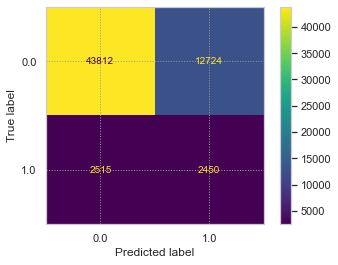

[[43812 12724]
 [ 2515  2450]]
Time: 2801.334497451782


In [81]:
hyperoptLGBM(max_evals=100)

Le modèle optimisé par HyperOPT n’arrive pas à dépasser les modèles précédents.

## 3.2. Avec Fonction de Coût Métiers (adaptée) 

Maintenant que la phase de référence réalisée, la fonction de coût métier (FCM) adaptée à la problématique est utiliser dans cette deuxième phase d’entrainement, puis les modèles de cette phase seront comparés aux modèles de la phase référence précédente.

In [139]:
hue='FCM'

# Fonction de Coût Métiers (FCM)
def custom_metric(y, y_pred, **kwargs):
        cm = confusion_matrix(y, y_pred)
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]
        
        regul = 0
        if tn+fn==0:
                regul = 1        
        n = tn/(tn+fn+regul)

        regul = 0
        if tp+fp==0:
                regul = 1
        prec = tp/(tp+fp+regul)
        
        # return metric
        Lambda = 10
        return ((Lambda+1)*n*prec)/(Lambda*n+prec)

### 3.2.1. Modèle Baseline : LogisticRegressionCV

Avant d'entrainer le modèle final, il faut d’abord établir un modèle de référence (baseline) pour évaluer l’évolution de la performance du modèle.
La Baseline choisie est une régression logistique cross-validée, qui pour prédire la classe, combine linéairement les variables pondérées plus des termes de régulation.

Socre: 0.5002701609013198


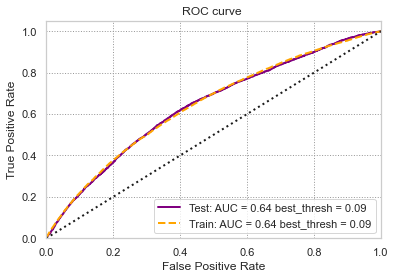

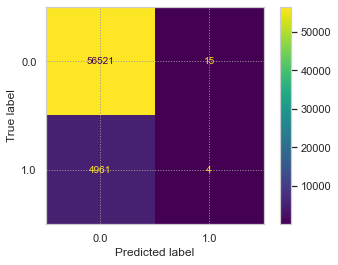

[[56521    15]
 [ 4961     4]]
Time: 617.2465028762817


In [83]:
train_baseline(custom_metric)

La nouvelle baseline a un taux de Faux Positifs plus faible, par rapport à la baseline de la première phase.

### 3.2.2. Modèle Classique : LGBM

Le modèle réel sélectionné est LightGBM, qui réalise du gradient boosting sur un arbre de décision de manière efficace et rapide avec moins de mémoire et une plus forte précision. Les hyperparamètres du modèle sont choisis à partir des noyaux/scripts Kaggle réalisé sur cette problématique.

In [140]:
# Fonction de calcul de la prédiction finale à partir des probabiltés de chaque classe
def roundPreds(preds, threshold=0.5):
    if threshold==None:
        threshold=0.5
    preds = (preds > threshold).astype(int)
    return preds    

# FCM adaptée à LGBM
def lgbm_metric(y, preds, threshold=0.5):   
    preds = roundPreds(preds, threshold)
    # # eval_name, eval_result, is_higher_better
    return 'custom_metric', custom_metric(y, preds), True

[LightGBM] [Info] Number of positive: 224321, number of negative: 224321
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.880000
[LightGBM] [Info] Total Bins 31994
[LightGBM] [Info] Number of data points in the train set: 448642, number of used features: 511
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 236 dense feature groups (100.97 MB) transferred to GPU in 0.056553 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 11
[1]	valid_0's binary_logloss: 0.694886	valid_0's custom_metric: 0.114273
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 11
[2]	valid_0's binary_logloss: 0

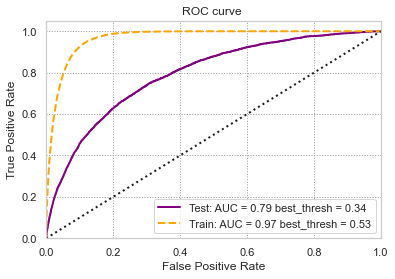

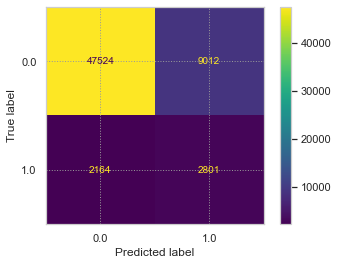

[[47524  9012]
 [ 2164  2801]]
Time: 1866.9449996948242


In [85]:
lgbmc = trainLGBM(lgbm_params, lgbm_metric, 'lgbmc')

Le modèle LGBM classique dans cette deuxième (avec la fonction de coût adapté) est équivalant au modèle de la première phase.

[LightGBM] [Info] Number of positive: 224321, number of negative: 224321
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.880000
[LightGBM] [Info] Total Bins 31994
[LightGBM] [Info] Number of data points in the train set: 448642, number of used features: 511
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 236 dense feature groups (100.97 MB) transferred to GPU in 0.059376 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[1]	valid_0's binary_logloss: 0.750791	valid_0's custom_metric: 0.111085
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[2]	valid_0's binary_logloss: 0.7

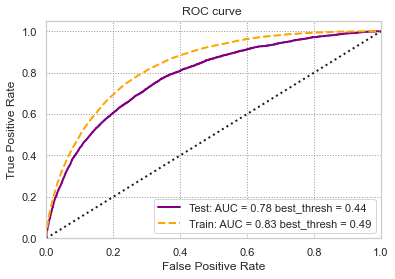

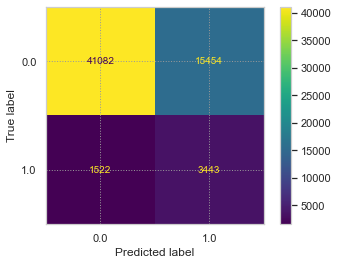

[[41082 15454]
 [ 1522  3443]]
Time: 45.04400014877319


In [86]:
lgbmlc = trainLGBM(lgbm_params2, lgbm_metric, 'lgbmlc')

Ce modèle est, aussi, équivalent à son homologue de la première phase.

[LightGBM] [Info] Number of positive: 179488, number of negative: 179488
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.878889
[LightGBM] [Info] Total Bins 31880
[LightGBM] [Info] Number of data points in the train set: 358976, number of used features: 510
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 236 dense feature groups (80.79 MB) transferred to GPU in 0.061699 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[Ligh

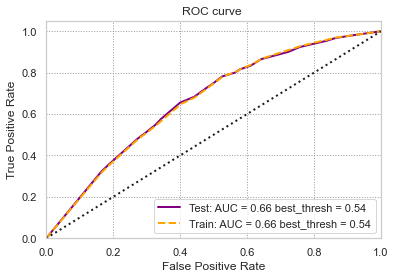

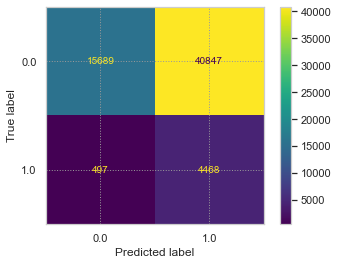

[[15689 40847]
 [  497  4468]]
Time: 21.153996467590332


In [142]:
lgbmlc_cv = trainLGBM_CV(lgbm_params2, lgbm_metric, 'lgbmlc_cv')

Le modèle LGBM validé, avec la fonction de coût métier adaptée, a une AUC équivamante à la première phase. En revanche, son taux de Faux Négatifs est plus faible au détriment du taux de Faux Positifs.

### 3.2.3. Optimisation du Modèle LGBM

Deux méthodes d’optimisation (semi-)automatique des hyperparamètres sont testées sur le modèle LGBM.

#### 3.2.3.1. FlaML

In [88]:
def custom_metric_flaml(
    X_test,
    y_test,
    estimator,
    labels,
    X_train,
    y_train,
    weight_test=None,
    weight_train=None,
    config=None,
    groups_test=None,
    groups_train=None,
):

    start = time.time()
    y_pred = estimator.predict(X_test)    
    pred_time = (time.time() - start) / len(X_test)
    test_loss = custom_metric(y_test, y_pred)    
    y_pred = estimator.predict(X_train)
    train_loss = custom_metric(y_train, y_pred)
    alpha = 0.5
    return test_loss * (1 + alpha) - alpha * train_loss, {
        "test_loss": test_loss,
        "train_loss": train_loss,
        "pred_time": pred_time,
    }

[flaml.automl: 09-12 22:36:01] {2565} INFO - task = classification
[flaml.automl: 09-12 22:36:01] {2567} INFO - Data split method: stratified
[flaml.automl: 09-12 22:36:01] {2570} INFO - Evaluation method: cv
[flaml.automl: 09-12 22:36:26] {2689} INFO - Minimizing error metric: customized metric
[flaml.automl: 09-12 22:36:26] {2831} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 09-12 22:36:26] {3133} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-12 22:37:32] {3266} INFO - Estimated sufficient time budget=657810s. Estimated necessary time budget=658s.
[flaml.automl: 09-12 22:37:32] {3313} INFO -  at 90.8s,	estimator lgbm's best error=0.7679,	best estimator lgbm's best error=0.7679
[flaml.automl: 09-12 22:37:32] {3133} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-12 22:38:43] {3313} INFO -  at 161.6s,	estimator lgbm's best error=0.7652,	best estimator lgbm's best error=0.7652
[flaml.automl: 09-12 22:38:43] {3133} INFO - iteration 2, current 

>>>>> Best hyperparmeter config: {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 34, 'learning_rate': 0.013282118938074527, 'log_max_bin': 8, 'colsample_bytree': 0.7635047932427287, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.09066154502089288}
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.679089	valid_0's custom_metric: 0.123534
[LightGBM] [Warning] Unknown parameter: log_max_bin
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.679022	valid_0's custom_metric: 0.123462
Socre: 0.6107442827826483


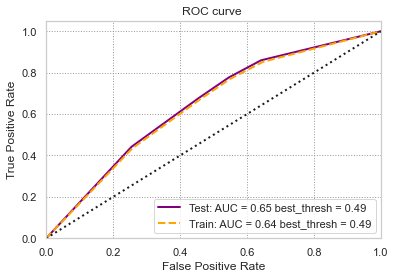

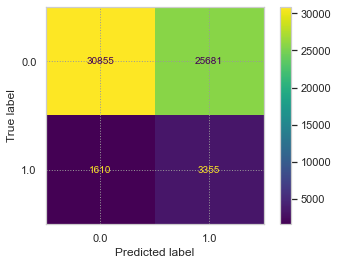

[[30855 25681]
 [ 1610  3355]]
Time: 3620.233990907669


In [89]:
flamlLGBM(time_budget=3600, metric=custom_metric_flaml, name='flamlgbmc')

Dans cette deuxième phase, l'optimisation du modèle avec FlaML donne de meilleurs résultats. Mais, ne produit toujours pas un très bon modèle.

#### 3.2.3.2. HyperOPT

>>>> Current params                                    
{'colsample_bytree': 0.10516973279148369, 'learning_rate': 0.2915214209914396, 'max_bin': 140, 'max_depth': 8, 'min_child_samples': 550, 'min_child_weight': 0.03393097854362498, 'n_estimators': 40, 'num_leaves': 67, 'reg_alpha': 3.1291487819773502, 'reg_lambda': 0.2540998085606089, 'sampling_strategy': 0.5781859286808033, 'subsample': 0.3387629991204758}
[LightGBM] [Warning] Unknown parameter: sampling_strategy
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.              
Early stopping, best iteration is:                     
[20]	valid_0's binary_logloss: 0.251261	valid_0's custom_metric: 0.496845
>>>> Current params                                    
{'colsample_bytree': 0.10516973279148369, 'learning_rate': 0.2915214209914396, 'max_bin': 140, 'max_depth': 8, 'min_child_samples': 550, 'min_child_weight': 0.03393097854362498, 'n_estimators': 40, 'num_leaves': 67, 'reg_alpha'

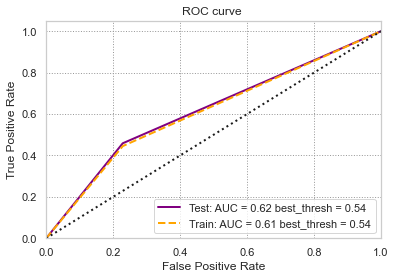

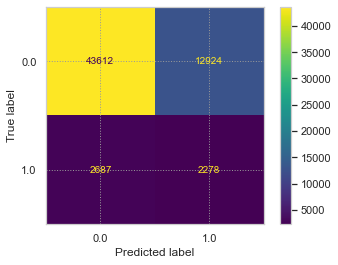

[[43612 12924]
 [ 2687  2278]]
Time: 3661.206495285034


In [90]:
hyperoptLGBM(max_evals=100, eval_metric=custom_metric, name='lgbmhc')

## 3.3. Comparaison

In [4]:
Perfs.to_csv('Perfs.csv', index=False)
Perfs

Model       AUC    FN      Time(s)  hue
0   baseline_auc  0.627506  4961   656.107998  AUC
1           lgbm  0.967045  2164   756.531997  AUC
2          lgbml  0.833568  1522    20.141994  AUC
3       lgbml_cv  0.662439   560    32.280500  AUC
4       flamlgbm  0.774896  4955  3689.800492  AUC
5          lgbmh  0.693211  2515  2801.334497  AUC
6   baseline_auc  0.640872  4961   617.246503  FCM
7           lgbm  0.967045  2164  1866.945000  FCM
8          lgbml  0.833568  1522    45.044000  FCM
9       lgbml_cv  0.662439   497    40.103998  FCM
10      flamlgbm  0.638382  1610  3620.233991  FCM
11         lgbmh  0.608277  2687  3661.206495  FCM

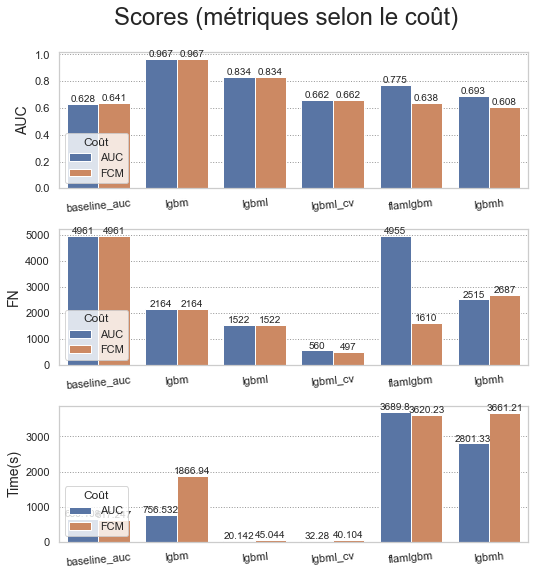

In [5]:
display_scores(Perfs, hue='Coût', yloc=0.95, y='métriques selon le coût', loc='lower left')

<p>Le meilleur modèle est celui cross-validé avec la fonction de coût métiers et les hyperparamètres plus légers (lgbmlc_cv).</p>

# 4. Interpretation du Modèle

Cette partie s’articule sur l’interprétation du modèle c-à-d l’explication du processus de décision du modèle pour le calcul de ses prédictions.

In [143]:
model = lgbmlc_cv

## 4.1. Description du Modèle

LightGBM fournit une fonction d’affichage de l’arbre de décision appris et qui représente le processus de décision du modèle pour ses prédictions.

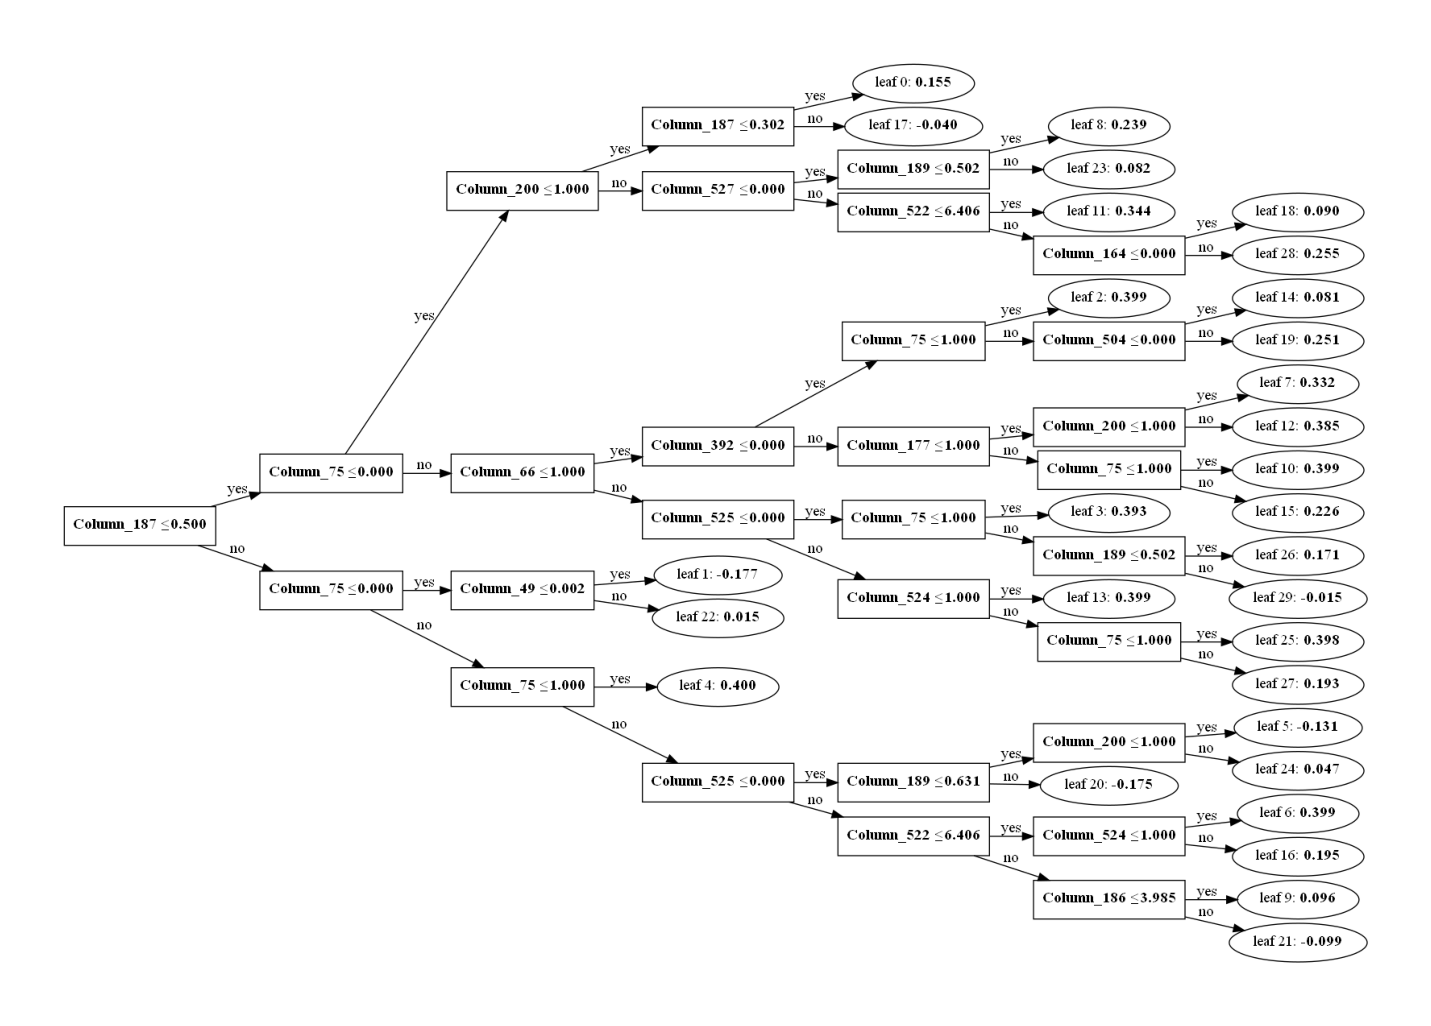

In [133]:
_= plot_tree(model, figsize=(5,2),  dpi=600)

## 4.2. Importance des features : SHAP

Le module SHAP, basée sur les Shapley-Values (la théorie des jeux), est utilisé afin de mesurer l’importance de la contribution (positive ou négative) de chaque variable dans le processus de prédiction du modèle : au niveau global (pour tout le modèle) et au niveau local (pour un individu en particulier).

### 4.2.1. Au niveau Global

SHAP permet de calculer et d’afficher l’importance des variables dans le processus de décision du modèle entrainé, en effectuant des séries de mélanges aléatoire et d’éliminations.

In [95]:
X = x_train
explainer = shap.TreeExplainer(model, X, model_output='probability')
shap_explanations = explainer(X)
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X)

 98%|===================| 240975/246004 [00:38<00:00]        

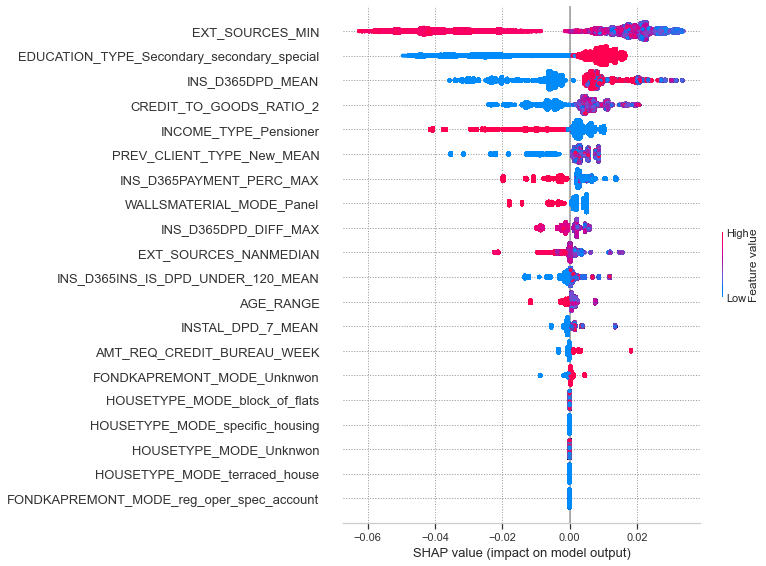

In [96]:
shap.summary_plot(shap_values, X, max_display=20)

### 4.2.1. Au niveau Local

SHAP permet aussi d’expliquer la prédiction faite par le modèle sur un seul individu, en montrant les variables les plus importantes dans la décision du modèle.

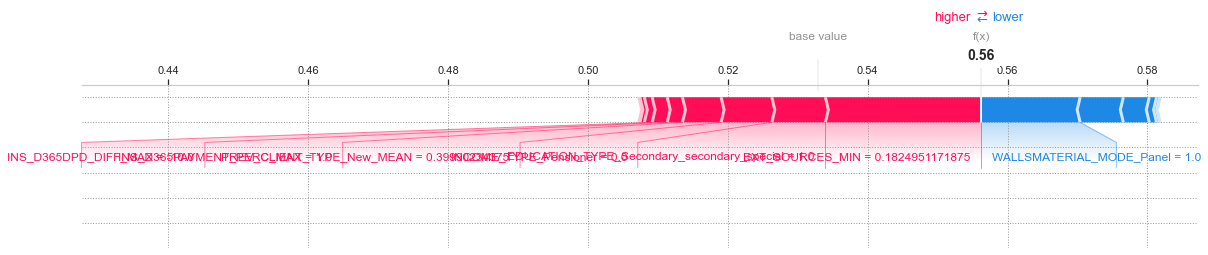

In [97]:
shap.plots.force(expected_value, shap_values[0], X.iloc[0, :], matplotlib=True)

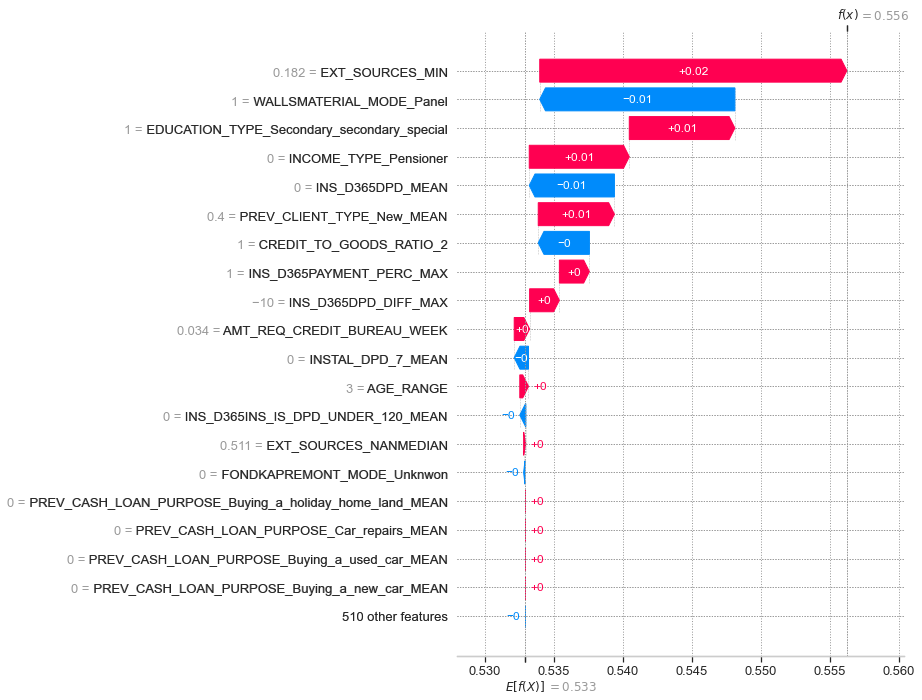

In [99]:
shap.plots.waterfall(shap_explanations[0], max_display=20)